In [88]:
import os
import sys
import operator
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss, mean_squared_error,SCORERS
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV, StratifiedKFold

In [89]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df.shape)
print(test_df.shape)

(14006, 3)
(3504, 2)


In [90]:
data = train_df.copy()
print(data['speed'].isnull().sum())
data.head()

0


,id,date,speed
0,0,1/1/2017 0:00,43.002930
1,1,1/1/2017 1:00,46.118696
2,2,1/1/2017 2:00,44.294158
3,3,1/1/2017 3:00,41.067468
4,4,1/1/2017 4:00,46.448653


In [91]:
data['date1'] = pd.to_datetime(data['date'], format = '%d/%m/%Y %H:%M')
data['date1'].head()

0   2017-01-01 00:00:00
1   2017-01-01 01:00:00
2   2017-01-01 02:00:00
3   2017-01-01 03:00:00
4   2017-01-01 04:00:00
Name: date1, dtype: datetime64[ns]

In [92]:
data['t_date'] = data['date1'].dt.date
data['t_time'] = data['date1'].dt.time

In [93]:
"""
"rain.csv" is weather statistics that I crawled from the website https://www.hko.gov.hk/tc/cis/dailyExtract.htm?y=2017&m=12
And in this file there are also some features I add manually, like 'holiday',which means that whether this day is HK holiday
"""
rain17 = pd.read_csv('rain.csv')

In [94]:
rain17['t_date'] = pd.to_datetime(rain17['t_date'], format = '%Y/%m/%d')
rain17['t_date'] = rain17['t_date'].dt.date
rain17['holiday'].fillna(0, inplace = True)
rain17['is_weekend'].fillna(0, inplace = True)
rain17['daybefore'].fillna(0, inplace = True)

In [95]:
"""
Merging
"""
temp = pd.merge(data, rain17, on = 't_date')
temp.to_csv('temp.csv')
temp.shape

(14006, 23)

In [96]:
train_df = pd.read_csv('temp.csv')

In [97]:
"""
In this part, I construct some new features from the original feature (year,month,day,hour)
"""

train_df['date'] = pd.to_datetime(train_df['date'], format = '%d/%m/%Y %H:%M')

to_one_hot = train_df['date'].dt.day_name()
days = pd.get_dummies(to_one_hot)
train_df = train_df.join(days)

day_to_onehot = pd.get_dummies(train_df['date'].dt.day)
train_df = train_df.join(day_to_onehot)

# hour_to_onehot = pd.get_dummies(train_df['date'].dt.hour)
# train_df = train_df.join(hour_to_onehot)

train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month

train_df['day'] = train_df['date'].dt.day

train_df['hour'] = train_df['date'].dt.hour

def rushhour(hour):
    if hour in [8,9]:
        return 'rush_morning'
    if hour in [18,19,20]:
        return 'rush_evening'

# def daypart(hour):
#     if hour in [2,3,4,5]:
#         return 'dawn'
#     elif hour in [6,7,8,9]:
#         return 'morning'
#     elif hour in [10,11,12,13]:
#         return 'noon'
#     elif hour in [14,15,16,17]:
#         return 'afternoon'
#     elif hour in [18,19,20,21]:
#         return 'evening'
#     else:
#         return 'midnight'

def daypart(hour):
    if hour in [0,1]:
        return 'h1'
    elif hour in [2,3]:
        return 'h2'
    elif hour in [4,5]:
        return 'h3'
    elif hour in [6,7]:
        return 'h4'
    elif hour in [8,9]:
        return 'h5'
    elif hour in [10,11]:
        return 'h6'
    elif hour in [12,13]:
        return 'h7'
    elif hour in [14,15]:
        return 'h8'
    elif hour in [16,17]:
        return 'h9'
    elif hour in [18,19]:
        return 'h10'
    elif hour in [20,21]:
        return 'h11'
    else:
        return 'h12'

dp = train_df['hour'].apply(daypart)
dayparts = pd.get_dummies(dp)
train_df = train_df.join(dayparts)

rh = train_df['hour'].apply(rushhour)
rush_hours = pd.get_dummies(rh)
train_df = train_df.join(rush_hours)

In [98]:
train_df.head()

,Unnamed: 0,id,date,speed,date1,t_date,t_time,holiday,daybefore,is_weekend,...,h2,h3,h4,h5,h6,h7,h8,h9,rush_evening,rush_morning
0,0,0,2017-01-01 00:00:00,43.002930,2017-01-01 00:00:00,2017-01-01,00:00:00,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2017-01-01 01:00:00,46.118696,2017-01-01 01:00:00,2017-01-01,01:00:00,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,2017-01-01 02:00:00,44.294158,2017-01-01 02:00:00,2017-01-01,02:00:00,1.0,0.0,1.0,...,1,0,0,0,0,0,0,0,0,0
3,3,3,2017-01-01 03:00:00,41.067468,2017-01-01 03:00:00,2017-01-01,03:00:00,1.0,0.0,1.0,...,1,0,0,0,0,0,0,0,0,0
4,4,4,2017-01-01 04:00:00,46.448653,2017-01-01 04:00:00,2017-01-01,04:00:00,1.0,0.0,1.0,...,0,1,0,0,0,0,0,0,0,0


# Training process

In [99]:
"""
In this part, I tried different combination of features. To ensure the code is easy to read, I only kept 4 of those combination.
"""
# features_to_use = ['year','hour','month','day','Monday','Wednesday','Tuesday','Thursday',
#                 'Friday','Sunday','Saturday',
#                    'h1','h2','h3','h4','h5','h6','h7','h8','h9','h10','h11','h12',
#                'holiday','is_weekend','weekday','temper','cloud','rain','wind','wet',
#                   'daybefore','rush_morning','rush_evening',10,15,16,22,28,'pressure']# feature 1
# features_to_use = ['year','hour','month','day','Monday','Wednesday','Tuesday','Thursday',
#                 'Friday','Sunday','Saturday',
#                    'h1','h2','h3','h4','h5','h6','h7','h8','h9','h10','h11','h12',
#                'holiday','is_weekend','weekday','temper','cloud','rain','wind','wet',
#                   'daybefore','rush_morning','rush_evening']# feature 2
# features_to_use = ['year','hour','month','day','Monday','Wednesday','Tuesday','Thursday',
#                 'Friday','Sunday','Saturday','h2','h3','h4','h5','h6','h7','h8','h9','h10','h11',
#                'holiday','is_weekend','sun','visibility','weekday','temper','cloud','rain','wind','wet',
#                   'daybefore','rush_evening','pressure']  # feature 3
features_to_use = ['year','hour','month','day','Monday','Wednesday','Tuesday','Thursday',
                'Friday','Sunday','Saturday','h2','h3','h4','h5','h6','h7','h8','h9','h10','h11',
               'holiday','is_weekend','weekday','temper','cloud','rain','wind','wet',
                  'daybefore','rush_evening','pressure']  # feature 4

X = train_df[features_to_use]
y = train_df['speed']

# Model tuning

In [38]:
"""
Hyperparameters tuning and cross validation
"""
xgb_model = xgb.XGBRegressor()
kfold = KFold(n_splits=5, shuffle=True, random_state=666) 

param_grid = {
    'learning_rate':[0.05,0.04],
    'max_depth':[9],
    'subsample':[0.8,0.9],  
    'n_estimators': list(range(300, 400, 20)),
    'gamma':[0.2],
    'reg_alpha':[2,3,4],
    'min_child_weight':[1]
}
grid_search = GridSearchCV(estimator=xgb_model, scoring='neg_mean_squared_error', param_grid=param_grid,verbose=1, n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)  

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.5min finished


In [39]:
print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}','\n')

Best: -10.473639028439262 using {'gamma': 0.2, 'learning_rate': 0.04, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 380, 'reg_alpha': 4, 'subsample': 0.8} 



In [108]:
kfold2 = KFold(n_splits=5, shuffle=True, random_state=333) 
scores = cross_validate(estimator=xgb_model, X=X, y=y, cv=kfold2, n_jobs=-1, 
                        scoring=['neg_mean_squared_error'])
scores

{'fit_time': array([10.28050542, 10.48196816, 10.48695493, 10.44406962, 10.48196864]),
 'score_time': array([0.13863087, 0.13065004, 0.13464022, 0.13663554, 0.13065052]),
 'test_neg_mean_squared_error': array([-11.2549479 ,  -9.99666711, -10.80706236, -10.04678234,
        -10.31369392])}

# Predict the result

In [ ]:
xgb_model = xgb.XGBRegressor(learning_rate=0.05,max_depth=9,n_estimators=360,reg_alpha=4,subsample=0.8,gamma=0.2,min_child_weight=1)

In [101]:
xgb_model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=360, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=4, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

Best: -10.88434304949807 using {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 350, 'subsample': 0.8} 
Best: -10.748485015272758 using {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 380, 'subsample': 0.8}   use features 1

Best: -10.701073329887727 using {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 380, 'subsample': 0.8}  use features 2  cv score 11.22

Best: -10.649892617966735 using {'learning_rate': 0.04, 'max_depth': 9, 'n_estimators': 380, 'subsample': 0.8}   use features 3 cv score 11.23

Best: -10.675140027543065 using {'learning_rate': 0.04, 'max_depth': 8, 'n_estimators': 390, 'subsample': 0.9}  use features 4 cv score 10.97
Best: -10.575227192509162 using {'gamma': 0.2, 'learning_rate': 0.04, 'max_depth': 9, 'n_estimators': 380, 'reg_alpha': 2, 'subsample': 0.8}  use features 4 cv score 10.39
Best: -10.55632423654518 using {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 360, 'reg_alpha': 4, 'subsample': 0.8}  use features 4 cv score 10.31(FINAL SUBMISSION)
xgb_model = xgb.XGBRegressor(learning_rate=0.04,max_depth=9,n_estimators=380,reg_alpha=4,subsample=0.8,gamma=0.2,min_child_weight=1) use features 3 cv score 10.38   (FINAL SUBMISSION)


In [84]:
# xgb_model = xgb.XGBRegressor(learning_rate=0.05, max_depth = 8, n_estimators = 380
#                             ,subsample = 0.8)
# xgb_model.fit(X,y)

In [85]:
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33660)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33660)
# # 87859
# X_train.shape, X_test.shape


In [86]:
# ans = model.predict(X_test)
# error = mean_squared_error(y_test, ans)
# print(error)
# print(model.score(X_test, y_test))

In [87]:
# model.feature_importances_

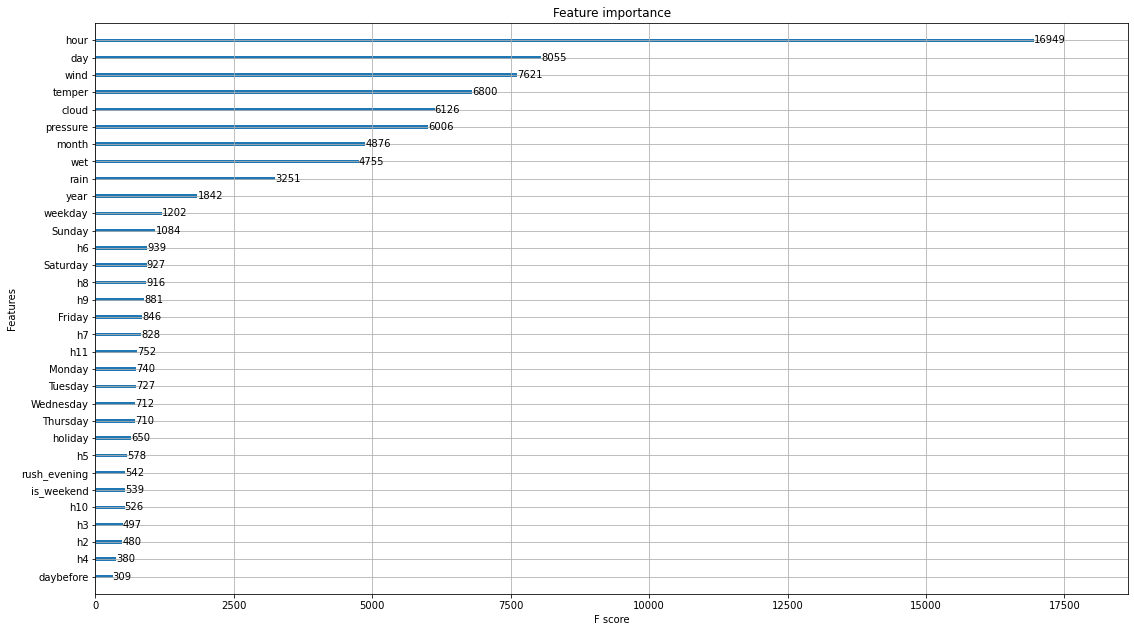

In [83]:
# feature importance, used for feature selection
from numpy import loadtxt
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(xgb_model)
fig = pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
pyplot.show()

Record down the prediction

In [102]:
"""
In this part, I did similar operation to test data including the merging with rain.csv

Then I used the model to predict the test set, and recorded down the speed.
"""

data1 = test_df.copy()
data1['date1'] = pd.to_datetime(data1['date'], format = '%d/%m/%Y %H:%M')
data1['t_date'] = data1['date1'].dt.date
data1['t_time'] = data1['date1'].dt.time
rain18 = pd.read_csv('rain.csv')
rain18['t_date'] = pd.to_datetime(rain18['t_date'], format = '%Y/%m/%d')
rain18['t_date'] = rain18['t_date'].dt.date
rain18['holiday'].fillna(0, inplace = True)
rain18['is_weekend'].fillna(0, inplace = True)
rain18['daybefore'].fillna(0, inplace = True)
temp1 = pd.merge(data1, rain18, on = 't_date')
temp1.to_csv('temp1.csv')

temp1['date'] = pd.to_datetime(temp1['date'], format = '%d/%m/%Y %H:%M')
to_one_hot = temp1['date'].dt.day_name()
days = pd.get_dummies(to_one_hot)
temp1 = temp1.join(days)
day_to_onehot = pd.get_dummies(temp1['date'].dt.day)
temp1 = temp1.join(day_to_onehot)
# hour_to_onehot1 = pd.get_dummies(temp1['date'].dt.hour)
# temp1 = temp1.join(hour_to_onehot1)
temp1['month'] = temp1['date'].dt.month
temp1['day'] = temp1['date'].dt.day
temp1['hour'] = temp1['date'].dt.hour
temp1['year'] = temp1['date'].dt.year
dp1 = temp1['hour'].apply(daypart)
dayparts1 = pd.get_dummies(dp1)
temp1 = temp1.join(dayparts1)
rh1 = temp1['hour'].apply(rushhour)
rush_hours1 = pd.get_dummies(rh1)
temp1 = temp1.join(rush_hours1)

In [103]:
trainx = temp1[features_to_use]
temp1['speed'] = xgb_model.predict(trainx)

In [104]:
temp1.to_csv("oop.csv")

In [105]:
df = pd.read_csv("oop.csv",usecols=['id', 'speed'])

In [106]:
df.to_csv('myresult.csv', index = False)